In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub


# Download the dataset and get the local path
path = kagglehub.dataset_download("hojjatk/mnist-dataset")
print("Path to dataset files:", path)
print("Files in the dataset folder:", os.listdir(path))


# Functions to Load MNIST IDX Files
def load_mnist_images(filename):
    """
    Load MNIST images from the IDX file.
    The file format:
      [offset] [type]          [value]          [description]
      0000     32 bit integer  0x00000803(2051) magic number
      0004     32 bit integer  number of images
      0008     32 bit integer  number of rows
      0012     32 bit integer  number of columns
      0016     unsigned byte   pixel
      ........
    """
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), byteorder='big')
        if magic != 2051:
            raise ValueError("Invalid magic number in image file: expected 2051, got {}".format(magic))
        num_images = int.from_bytes(f.read(4), byteorder='big')
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        num_cols = int.from_bytes(f.read(4), byteorder='big')
        # Read the rest of the data (unsigned bytes)
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape((num_images, num_rows * num_cols))
        return data

def load_mnist_labels(filename):
    """
    Load MNIST labels from the IDX file.
    The file format:
      [offset] [type]          [value]          [description]
      0000     32 bit integer  0x00000801(2049) magic number
      0004     32 bit integer  number of items
      0008     unsigned byte   label
      ........
    """
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), byteorder='big')
        if magic != 2049:
            raise ValueError("Invalid magic number in label file: expected 2049, got {}".format(magic))
        num_labels = int.from_bytes(f.read(4), byteorder='big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# Identify the IDX files in the downloaded folder

# We expect files for training and testing images/labels.
# We'll try the dot-version names first.
train_images_file = os.path.join(path, "train-images.idx3-ubyte")
train_labels_file = os.path.join(path, "train-labels.idx1-ubyte")
test_images_file  = os.path.join(path, "t10k-images.idx3-ubyte")
test_labels_file  = os.path.join(path, "t10k-labels.idx1-ubyte")

# If not found, try alternate names with a hyphen.
if not os.path.exists(train_images_file):
    train_images_file = os.path.join(path, "train-images-idx3-ubyte")
if not os.path.exists(train_labels_file):
    train_labels_file = os.path.join(path, "train-labels-idx1-ubyte")
if not os.path.exists(test_images_file):
    test_images_file = os.path.join(path, "t10k-images-idx3-ubyte")
if not os.path.exists(test_labels_file):
    test_labels_file = os.path.join(path, "t10k-labels-idx1-ubyte")

print("Using training images file:", train_images_file)
print("Using training labels file:", train_labels_file)
print("Using test images file:", test_images_file)
print("Using test labels file:", test_labels_file)


# Load the MNIST dataset from IDX files
X_train_full = load_mnist_images(train_images_file)
y_train_full = load_mnist_labels(train_labels_file)
X_test_full  = load_mnist_images(test_images_file)
y_test_full  = load_mnist_labels(test_labels_file)


# Convert images to float and normalize to [0, 1]
X_train_full = X_train_full.astype(np.float64) / 255.0
X_test_full  = X_test_full.astype(np.float64) / 255.0



Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1
Files in the dataset folder: ['t10k-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-labels.idx1-ubyte', 'train-images-idx3-ubyte', 't10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-images.idx3-ubyte']
Using training images file: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1/train-images.idx3-ubyte
Using training labels file: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1/train-labels.idx1-ubyte
Using test images file: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1/t10k-images.idx3-ubyte
Using test labels file: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1/t10k-labels.idx1-ubyte


"""
    Perform PCA on X and retain enough principal components to explain
    at least variance_threshold of the total variance.
    
    Returns:
      components: principal directions (n_features x k)
      mean: mean vector of X (for transforming new data)
      X_projected: projection of X onto the selected components (n_samples x k)
      explained_variances: eigenvalues corresponding to the selected components
    """

In [27]:
def pca(X, variance_threshold=0.95):

    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    #covariance matrix
    cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)


    #eigenvalues and eigenvectors(since covariance matrix is symmetric)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)


    # Sort in descending order
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]


    # Determine number of components needed to reach the variance threshold
    total_variance = np.sum(eigenvalues)
    cum_variance = np.cumsum(eigenvalues) / total_variance
    k = np.searchsorted(cum_variance, variance_threshold) + 1


    # Select the top-k eigenvectors
    components = eigenvectors[:, :k]
    X_projected = np.dot(X_centered, components)
    explained_variances = eigenvalues[:k]
    return components, mean, X_projected, explained_variances


#Project new data X using the PCA mean and components computed from training
def pca_transform(X, mean, components):
    return np.dot((X - mean), components)

    """
    Computing the FDA projection matrix.
    
    Parameters:
      X: (n_samples, n_features) data matrix.
      y: (n_samples,) labels.
      n_components: desired number of projection directions (<= C-1)
      
    Returns:
      W: Projection matrix (n_features, n_components)
    """

In [28]:
def fda(X, y, n_components):

    classes = np.unique(y)
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0)

    SW = np.zeros((n_features, n_features))
    SB = np.zeros((n_features, n_features))

    for cls in classes:
        X_cls = X[y == cls]
        n_cls = X_cls.shape[0]
        cls_mean = np.mean(X_cls, axis=0)

        # Within-class scatter
        X_cls_centered = X_cls - cls_mean
        SW += np.dot(X_cls_centered.T, X_cls_centered)

        # Between-class scatter
        diff = (cls_mean - overall_mean).reshape(-1, 1)
        SB += n_cls * np.dot(diff, diff.T)

    # Solved the generalized eigenvalue problem: inv(SW)*SB
    A = np.dot(np.linalg.pinv(SW), SB)
    eigenvalues, eigenvectors = np.linalg.eig(A)
    sorted_idx = np.argsort(eigenvalues.real)[::-1]
    eigenvectors = eigenvectors[:, sorted_idx]
    W = eigenvectors[:, :n_components].real
    return W

   """
    Train an LDA classifier assuming a common covariance matrix.
    
    Returns:
      means: dictionary of class mean vectors.
      inv_pooled_cov: inverse of the pooled covariance matrix.
      priors: dictionary of class priors.
    """

    """
    Predict labels for X using the LDA discriminant functions.
    Discriminant function: g(x) = x^T * inv_cov * mu - 0.5 * mu^T * inv_cov * mu + log(prior)
    """

 """
    Train a QDA classifier by computing class-specific mean and covariance.
    
    Returns:
      params: dictionary with each class's parameters (mean, covariance, inv_cov, determinant, prior)
    """

In [29]:
def train_lda(X, y):

    classes = np.unique(y)
    n_features = X.shape[1]
    means = {}
    pooled_cov = np.zeros((n_features, n_features))
    total_samples = X.shape[0]

    for cls in classes:
        X_cls = X[y == cls]
        n_cls = X_cls.shape[0]
        mu_cls = np.mean(X_cls, axis=0)
        means[cls] = mu_cls
        X_cls_centered = X_cls - mu_cls
        cov_cls = np.dot(X_cls_centered.T, X_cls_centered) / (n_cls - 1)
        pooled_cov += (n_cls - 1) * cov_cls

    pooled_cov /= (total_samples - len(classes))
    inv_pooled_cov = np.linalg.pinv(pooled_cov)
    priors = {cls: np.mean(y == cls) for cls in classes}
    return means, inv_pooled_cov, priors

def predict_lda(X, means, inv_cov, priors):

    predictions = []
    classes = list(means.keys())
    for x in X:
        scores = {}
        for cls in classes:
            mu = means[cls]
            score = np.dot(x, np.dot(inv_cov, mu)) - 0.5 * np.dot(mu, np.dot(inv_cov, mu)) + np.log(priors[cls])
            scores[cls] = score
        predictions.append(max(scores, key=scores.get))
    return np.array(predictions)










# QDA Classifier
def train_qda(X, y):
    classes = np.unique(y)
    params = {}
    for cls in classes:
        X_cls = X[y == cls]
        n_cls = X_cls.shape[0]
        mu = np.mean(X_cls, axis=0)
        X_cls_centered = X_cls - mu
        cov = np.dot(X_cls_centered.T, X_cls_centered) / (n_cls - 1)
        inv_cov = np.linalg.pinv(cov)
        det_cov = np.linalg.det(cov) + 1e-6  # stability epsilon
        params[cls] = {
            'mean': mu,
            'cov': cov,
            'inv_cov': inv_cov,
            'det': det_cov,
            'prior': np.mean(y == cls)
        }
    return params

def predict_qda(X, params):
    """
    Predict labels for X using the QDA discriminant functions.
    Discriminant function: g(x) = -0.5*log(det_cov) - 0.5*(x - mu)^T * inv_cov * (x - mu) + log(prior)
    """
    predictions = []
    classes = list(params.keys())
    for x in X:
        scores = {}
        for cls in classes:
            mu = params[cls]['mean']
            inv_cov = params[cls]['inv_cov']
            det_cov = params[cls]['det']
            prior = params[cls]['prior']
            diff = x - mu
            score = -0.5 * np.log(det_cov) - 0.5 * np.dot(diff.T, np.dot(inv_cov, diff)) + np.log(prior)
            scores[cls] = score
        predictions.append(max(scores, key=scores.get))
    return np.array(predictions)


**Data Preprocessing**

In [30]:

# Filter only classes 0, 1, and 2.
selected_classes = [0, 1, 2]
train_filter = np.isin(y_train_full, selected_classes)
test_filter = np.isin(y_test_full, selected_classes)

X_train_filtered = X_train_full[train_filter]
y_train_filtered = y_train_full[train_filter]
X_test_filtered  = X_test_full[test_filter]
y_test_filtered  = y_test_full[test_filter]

# Randomly select 100 samples per class for both training and testing.
def sample_per_class(X, y, samples_per_class=100):
    X_sampled = []
    y_sampled = []
    for cls in selected_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        selected = idx[:samples_per_class]
        X_sampled.append(X[selected])
        y_sampled.append(y[selected])
    return np.concatenate(X_sampled, axis=0), np.concatenate(y_sampled, axis=0)

X_train, y_train = sample_per_class(X_train_filtered, y_train_filtered, samples_per_class=100)
X_test, y_test   = sample_per_class(X_test_filtered, y_test_filtered, samples_per_class=100)

print("Train set shape:", X_train.shape)
print("Test set shape: ", X_test.shape)

Train set shape: (300, 784)
Test set shape:  (300, 784)


In [31]:

# 1. MLE Parameter Estimation (Per Class)
print("\nMLE Estimates per class:")
mle_params = {}
for cls in selected_classes:
    X_cls = X_train[y_train == cls]
    mu, cov = compute_mean_and_cov(X_cls)
    mle_params[cls] = {'mean': mu, 'cov': cov}
    print(f"Class {cls}: mean shape {mu.shape}, cov shape {cov.shape}")






# 2. PCA (Dimensionality Reduction)
# (a) PCA retaining 95% variance.
components_95, mean_pca95, X_train_pca95, ev_95 = pca(X_train, variance_threshold=0.95)
X_test_pca95 = pca_transform(X_test, mean_pca95, components_95)
print("\nPCA (95% variance): n_components =", components_95.shape[1])

# (b) PCA retaining 90% variance.
components_90, mean_pca90, X_train_pca90, ev_90 = pca(X_train, variance_threshold=0.90)
X_test_pca90 = pca_transform(X_test, mean_pca90, components_90)
print("PCA (90% variance): n_components =", components_90.shape[1])

# (c) PCA with only the first 2 principal components.
# Use a very high variance threshold to get all components, then manually select 2.
components_2, mean_pca2, X_train_pca2, ev_2 = pca(X_train, variance_threshold=0.9999)
components_2 = components_2[:, :2]
X_train_pca2 = pca_transform(X_train, mean_pca2, components_2)
X_test_pca2  = pca_transform(X_test, mean_pca2, components_2)
print("PCA with 2 components: n_components = 2")












# 3. FDA Projection (using PCA 95% features)

# For FDA, we use the PCA (95%) features.
# With 3 classes, maximum FDA projection dimension is 2.
W_fda = fda(X_train_pca95, y_train, n_components=2)
X_train_fda = np.dot(X_train_pca95, W_fda)
X_test_fda  = np.dot(X_test_pca95, W_fda)



MLE Estimates per class:
Class 0: mean shape (784,), cov shape (784, 784)
Class 1: mean shape (784,), cov shape (784, 784)
Class 2: mean shape (784,), cov shape (784, 784)

PCA (95% variance): n_components = 82
PCA (90% variance): n_components = 51
PCA with 2 components: n_components = 2



 Classification on PCA (95% variance) features 
LDA:  Train Accuracy = 100.00%, Test Accuracy = 96.00%
QDA:  Train Accuracy = 100.00%, Test Accuracy = 86.67%

Classification on FDA-projected (2D) features (LDA)
LDA on FDA: Train Accuracy = 100.00%, Test Accuracy = 96.00%

 Classification on PCA (90% variance) features (LDA)
LDA: Train Accuracy = 99.00%, Test Accuracy = 95.33%

Classification on PCA (2 components) features (LDA)
LDA: Train Accuracy = 91.67%, Test Accuracy = 93.67%


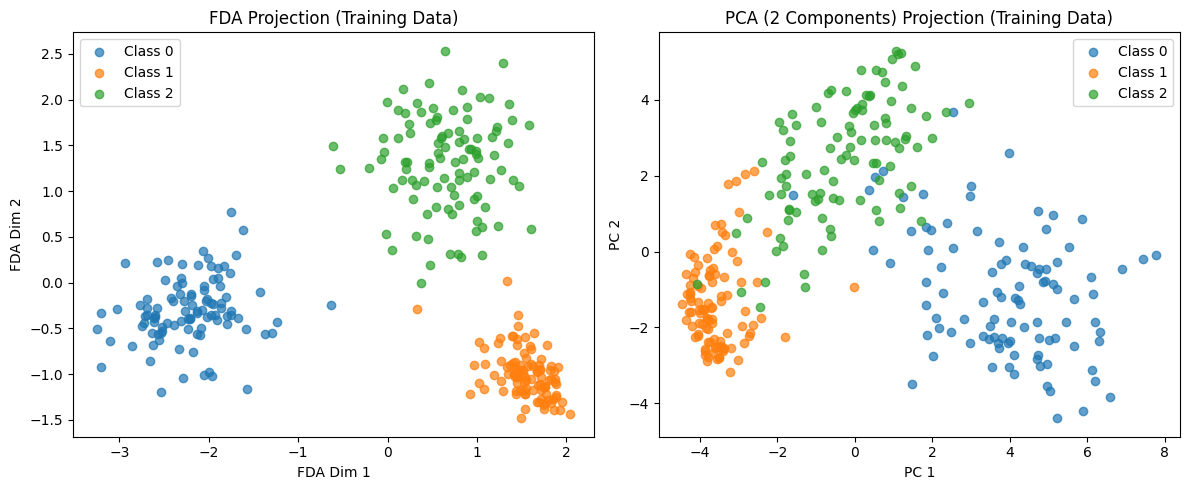

In [32]:

# 4. Discriminant Analysis Classification


# (A) Classification on PCA (95% variance) features

# LDA on PCA (95%) features.
means_lda, inv_cov_lda, priors_lda = train_lda(X_train_pca95, y_train)
pred_train_lda = predict_lda(X_train_pca95, means_lda, inv_cov_lda, priors_lda)
pred_test_lda  = predict_lda(X_test_pca95, means_lda, inv_cov_lda, priors_lda)
acc_train_lda = accuracy(y_train, pred_train_lda)
acc_test_lda  = accuracy(y_test, pred_test_lda)


# QDA on PCA (95%) features.
params_qda = train_qda(X_train_pca95, y_train)
pred_train_qda = predict_qda(X_train_pca95, params_qda)
pred_test_qda  = predict_qda(X_test_pca95, params_qda)
acc_train_qda = accuracy(y_train, pred_train_qda)
acc_test_qda  = accuracy(y_test, pred_test_qda)

print("\n Classification on PCA (95% variance) features ")
print("LDA:  Train Accuracy = {:.2f}%, Test Accuracy = {:.2f}%".format(acc_train_lda*100, acc_test_lda*100))
print("QDA:  Train Accuracy = {:.2f}%, Test Accuracy = {:.2f}%".format(acc_train_qda*100, acc_test_qda*100))
















# (B) Classification on FDA-projected (2D) features (using LDA)
means_fda, inv_cov_fda, priors_fda = train_lda(X_train_fda, y_train)
pred_train_fda = predict_lda(X_train_fda, means_fda, inv_cov_fda, priors_fda)
pred_test_fda  = predict_lda(X_test_fda, means_fda, inv_cov_fda, priors_fda)
acc_train_fda = accuracy(y_train, pred_train_fda)
acc_test_fda  = accuracy(y_test, pred_test_fda)

print("\nClassification on FDA-projected (2D) features (LDA)")
print("LDA on FDA: Train Accuracy = {:.2f}%, Test Accuracy = {:.2f}%".format(acc_train_fda*100, acc_test_fda*100))





#(C) Classification on PCA (90% variance) features using LDA
means_lda_90, inv_cov_lda_90, priors_lda_90 = train_lda(X_train_pca90, y_train)
pred_train_lda_90 = predict_lda(X_train_pca90, means_lda_90, inv_cov_lda_90, priors_lda_90)
pred_test_lda_90  = predict_lda(X_test_pca90, means_lda_90, inv_cov_lda_90, priors_lda_90)
acc_train_90 = accuracy(y_train, pred_train_lda_90)
acc_test_90  = accuracy(y_test, pred_test_lda_90)

print("\n Classification on PCA (90% variance) features (LDA)")
print("LDA: Train Accuracy = {:.2f}%, Test Accuracy = {:.2f}%".format(acc_train_90*100, acc_test_90*100))





#(D) Classification on PCA with only 2 principal components (LDA)
means_lda_2, inv_cov_lda_2, priors_lda_2 = train_lda(X_train_pca2, y_train)
pred_train_lda_2 = predict_lda(X_train_pca2, means_lda_2, inv_cov_lda_2, priors_lda_2)
pred_test_lda_2  = predict_lda(X_test_pca2, means_lda_2, inv_cov_lda_2, priors_lda_2)
acc_train_2 = accuracy(y_train, pred_train_lda_2)
acc_test_2  = accuracy(y_test, pred_test_lda_2)

print("\nClassification on PCA (2 components) features (LDA)")
print("LDA: Train Accuracy = {:.2f}%, Test Accuracy = {:.2f}%".format(acc_train_2*100, acc_test_2*100))


# 5. Visualizations



plt.figure(figsize=(12, 5))

# (A) FDA 2D Projection
plt.subplot(1, 2, 1)
for cls in selected_classes:
    idx = (y_train == cls)
    plt.scatter(X_train_fda[idx, 0], X_train_fda[idx, 1], label=f"Class {cls}", alpha=0.7)
plt.xlabel("FDA Dim 1")
plt.ylabel("FDA Dim 2")
plt.title("FDA Projection (Training Data)")
plt.legend()







# (B) PCA (2 Components) Projection
plt.subplot(1, 2, 2)
for cls in selected_classes:
    idx = (y_train == cls)
    plt.scatter(X_train_pca2[idx, 0], X_train_pca2[idx, 1], label=f"Class {cls}", alpha=0.7)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA (2 Components) Projection (Training Data)")
plt.legend()

plt.tight_layout()
plt.show()
